Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

1. Baixe os dados aqui.

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do TSE (Links para um site externo)Links para um site externo, pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos.

2. Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para um site externo para construir seus modelos de regressão. Isso implica, dentre outras coisas:

    1. Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.
    2. Construir modelos de regressão com (ridge e lasso) e sem regularização.
    3. Considerar também modelos de regressão não paramétrica como K-NN.
    4. Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests).
    5. Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados.
    6. Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.
    
3. Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.
    1. Dica: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados.
    
4. Responder:
    1. Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.


In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNet, Lasso, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

## Análise dos dados 

### Leitura dos dados

In [80]:
data = pd.read_csv("dados/eleicoes_2006_a_2010.csv")
df_data = pd.DataFrame(data) # load the dataset as a pandas data frame

In [81]:
df_data.head(10)

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401
5,2006,10003,JOSÉ RODRIGUES DOS SANTOS NETO,PI,PCO,6,6,1771.21,295.201667,NaN,...,9,9,1771.21,196.801111,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),SERVIDOR PÚBLICO FEDERAL,1822
6,2006,10003,JOSÉ TOMAZ DA SILVA,MS,PRONA,14,7,697.00,99.571429,NaN,...,17,10,696.91,69.691000,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),MÉDICO,317
7,2006,10003,LUIZ CARLOS MUNHOZ MEIRA,MG,PPS,2,2,70000.00,35000.000000,NaN,...,332,278,66016.95,237.471043,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),SERVIDOR PÚBLICO FEDERAL,2591
8,2006,10004,EDILSON VEIRA ROCHA,AP,PT,2,2,6065.00,3032.500000,6065.0,...,10,10,6060.42,606.042000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),"FEIRANTE, AMBULANTE E MASCATE",2551
9,2006,10004,EDUARDO VALVERDE ARAÚJO ALVES,RO,PT,68,65,105813.20,1627.895385,9575.0,...,68,67,110818.20,1654.002985,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),DEPUTADO,34631


### Pré-processamento dos dados

- Transformação das features numéricas enviesadas usando log(feature + 1) - isto tornará as features normais;
- Substituição dos valores numéricos ausentes (NaN's) pela média de suas respectivas colunas;
- Transformação das variáveis categóricas.

#### Enviesamento de features numéricas

Através dos histogramas abaixo vemos que as variáveis analisadas precisam de normalização, porque a distribuição dos seus valores não está igual.

In [82]:
# function to plot a histogram of each variable
def plot_histogram(feature):
    # log (feature + 1) because of features with values 0
    feature = pd.DataFrame({"1. " + feature: df_data[feature], "2. log(" + feature + ")": np.log1p(df_data[feature])})
    feature.hist() # TODO check how to increase the number of bins

# function to transform skewed variables using log(feature + 1)
def transform_skewed_var(feature):
    df_data[feature] = np.log1p(df_data[feature])

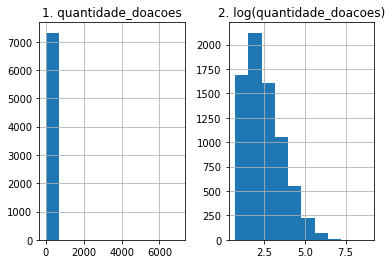

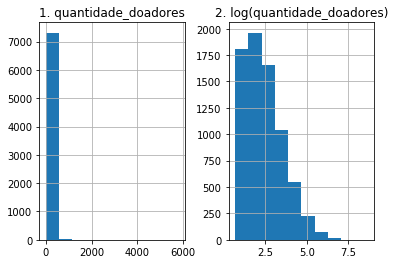

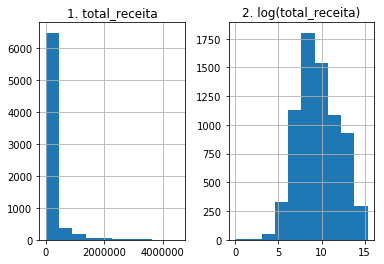

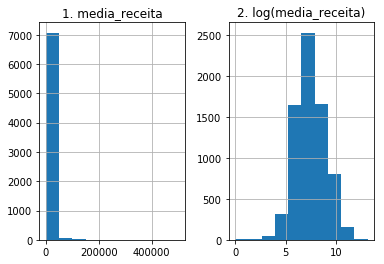

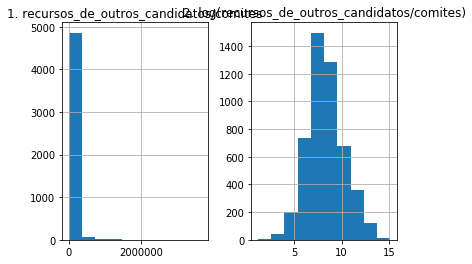

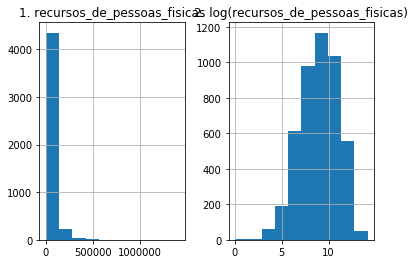

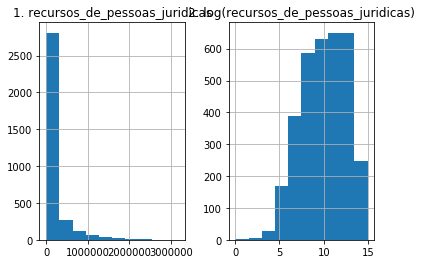

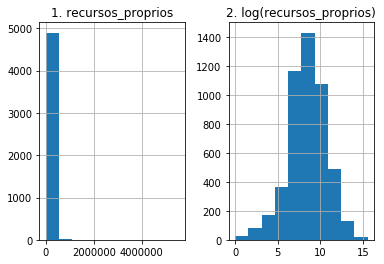

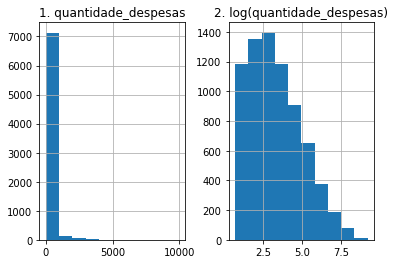

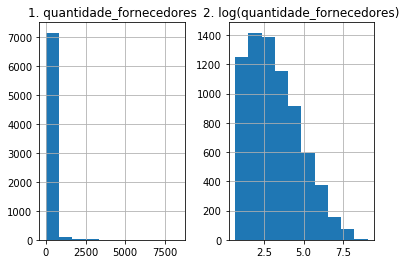

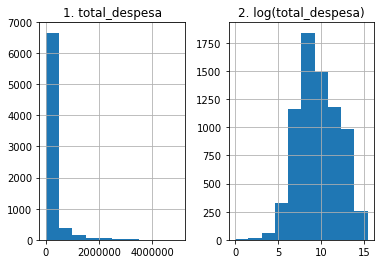

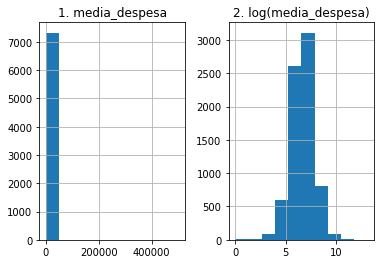

In [83]:
columns = "quantidade_doacoes quantidade_doadores total_receita media_receita recursos_de_outros_candidatos/comites recursos_de_pessoas_fisicas recursos_de_pessoas_juridicas recursos_proprios quantidade_despesas quantidade_fornecedores total_despesa media_despesa".split()

for feature in columns:
    plot_histogram(feature)
    transform_skewed_var(feature)    

#### Features com valores numéricos ausentes (NaN) 

Abaixo veremos quais as variáveis com valores ausentes (NaN).

In [84]:
df_data.isnull().any()

ano                                      False
sequencial_candidato                     False
nome                                     False
uf                                       False
partido                                  False
quantidade_doacoes                       False
quantidade_doadores                      False
total_receita                             True
media_receita                             True
recursos_de_outros_candidatos/comites     True
recursos_de_pessoas_fisicas               True
recursos_de_pessoas_juridicas             True
recursos_proprios                         True
quantidade_despesas                      False
quantidade_fornecedores                  False
total_despesa                            False
media_despesa                            False
cargo                                    False
sexo                                     False
grau                                     False
estado_civil                             False
ocupacao     

As variáveis **recursos_de_outros_candidatos/comites**, **recursos_de_pessoas_fisicas**, **recursos_de_pessoas_juridicas** e **recursos_proprios** são as que possuem valores ausentes e, portanto, serão substituídos pela média dos valores da respectiva variável. 

In [85]:
#filling NA's with the mean of the column:
df_data = df_data.fillna(df_data.mean())

df_data.isnull().any()

ano                                      False
sequencial_candidato                     False
nome                                     False
uf                                       False
partido                                  False
quantidade_doacoes                       False
quantidade_doadores                      False
total_receita                            False
media_receita                            False
recursos_de_outros_candidatos/comites    False
recursos_de_pessoas_fisicas              False
recursos_de_pessoas_juridicas            False
recursos_proprios                        False
quantidade_despesas                      False
quantidade_fornecedores                  False
total_despesa                            False
media_despesa                            False
cargo                                    False
sexo                                     False
grau                                     False
estado_civil                             False
ocupacao     

#### Tranformação das variáveis categóricas

As variáveis categóricas presentes nos dados, como **ocupação** e **estado_civil**, serão transformadas em variáveis numéricas, a fim de permitir a sua utilização nos modelos de regressão logo a seguir.

In [86]:
df_data = pd.get_dummies(df_data)

df_data.head(10)

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,...,"ocupacao_TÉCNICO DE OBRAS CIVIS, ESTRADAS, SANEAMENTO E ASSEMELHADOS",ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,2006,10001,1.945910,1.945910,9.717218,7.925760,8.324939,9.105091,8.748464,7.170888,...,0,0,0,0,0,0,1,0,0,0
1,2006,10002,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,...,0,0,0,0,0,0,0,0,0,0
2,2006,10002,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,...,0,0,0,0,0,0,0,0,0,0
3,2006,10002,1.945910,1.945910,8.007074,6.216979,8.324939,7.048386,7.004991,6.621406,...,0,0,0,0,0,0,0,0,0,0
4,2006,10003,3.891820,3.891820,9.634619,7.466020,8.324939,10.837206,10.011960,11.141035,...,0,0,0,0,0,0,0,0,0,0
5,2006,10003,1.945910,1.945910,7.479983,5.691041,8.324939,8.984406,10.011960,7.479983,...,0,0,0,0,0,0,0,0,0,0
6,2006,10003,2.708050,2.079442,6.548219,4.610868,8.324939,7.116394,10.011960,8.431020,...,0,0,0,0,0,0,0,0,0,0
7,2006,10003,1.098612,1.098612,11.156265,10.463132,8.324939,8.984406,10.011960,11.156265,...,0,0,0,0,0,0,0,0,0,0
8,2006,10004,1.098612,1.098612,8.710455,8.017472,8.710455,8.984406,10.011960,8.431020,...,0,0,0,0,0,0,0,0,0,0
9,2006,10004,4.234107,4.189655,11.569440,7.395657,9.167015,10.987734,10.165890,9.711176,...,0,0,0,0,0,0,0,0,0,0


### Divisão dos dados em treinamento e validação

Abaixo, o conjunto de dados utilizado será particionado em treino, para servir para a criação dos modelos de regressão e em validação, que será usado para avaliar a qualidade do modelo.

In [87]:
data_train = df_data.loc[df_data["ano"] == 2006]
y_train = data_train.votos
X_train = data_train.drop("votos", 1)
print(X_train.shape)
print(y_train.shape)

data_validation = df_data.loc[df_data["ano"] == 2010]
y_validation = data_validation.votos
X_validation = data_validation.drop("votos", 1)
print(X_validation.shape)
print(y_validation.shape)

(3388, 7037)
(3388,)
(3942, 7037)
(3942,)


## Implementação dos Modelos de regressão

### 1. Modelos de regressão sem regularização

In [88]:
# function to calculate the RMSE of the model with cross validation
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5))
    return(rmse)

#### 1.1 Implementando o modelo de regressão Ridge

In [89]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

print(model_ridge.coef_)
print(model_ridge.score(X_validation, y_validation))

[ 0.00000000e+00  5.21960914e-01 -2.62951345e+03 ...  2.00953287e+03
  1.05014315e+04 -6.99573371e+03]
-3695375172111.76


O hiperparâmetro do Rigde é o alpha - um parâmetro de regularização que mede quão flexível é o modelo. Quanto maior a regularização, menos propenso será o nosso modelo de overfitting. No entanto, também perderá a flexibilidade e poderá não capturar todo o padrão dos dados.

Testaremos alguns valores para alpha e usaremos o melhor para treinar o modelo.

Text(0,0.5,'rmse')

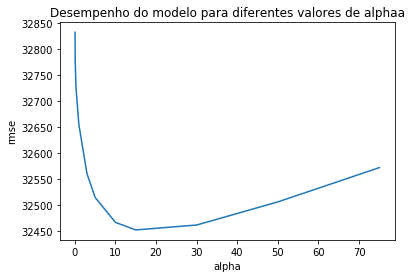

In [90]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge_rmse = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

series = pd.Series(cv_ridge_rmse, index = alphas)
series.plot(title = "Desempenho do modelo para diferentes valores de alphaa")
plt.xlabel("alpha")
plt.ylabel("rmse")

Observe a curva em forma de U acima. Quando o alpha é muito grande, a regularização é muito forte e o modelo não consegue capturar todas as complexidades dos dados - o erro volta a aumentar. Se, no entanto, deixarmos o modelo ser muito flexível (alpha pequeno), o modelo tende ao overfitting. Um valor de alpha = 15 parece o melhor, com base no gráfico acima.

In [91]:
print("RMSE min: ", cv_ridge.min())

('RMSE min: ', 32452.03670051762)


In [92]:
model_ridge = Ridge(alpha = 15)
model_ridge.fit(X_train, y_train)

print(model_ridge.coef_)
print(model_ridge.score(X_train, y_train))
print(model_ridge.score(X_validation, y_validation))

[ 0.00000000e+00  7.72949561e-01 -2.31649591e+02 ...  1.05597613e+03
  3.93929023e+03 -1.34458970e+03]
0.5731511311965755
-8103728087638.565


#### 1.2 Implementando o modelo de regressão Lasso

In [93]:
model_lasso = Lasso()
model_lasso.fit(X_train, y_train)

/home/veruska/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [94]:
print(model_lasso.coef_)
print(model_lasso.score(X_train, y_train))
print(model_lasso.score(X_validation, y_validation))

[ 0.00000000e+00 -7.63863465e-02 -3.20989515e+03 ...  2.25001224e+03
  2.46804911e+03 -9.68704400e+02]
0.9951883657153328
-79143286090.9716


Vamos agora usar o Lasso CV para descobrir o melhor alpha para nós.

In [95]:
model_lasso_cv = LassoCV(alphas = [0.0005, 0.1, 0.5, 1, 50, 100]).fit(X_train, y_train)

/home/veruska/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/veruska/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/veruska/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/veruska/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

In [96]:
print(model_lasso_cv.coef_)
print(model_lasso_cv.score(X_train, y_train))
print(model_lasso_cv.score(X_validation, y_validation))

[ 0.         -0.27009879  0.         ...  0.          0.
 -0.        ]
0.7087712280030942
-989527190481.604


### 2. Modelos de regressão não parámetrica

#### 2.1 Implementando o modelo de regressão kNN

In [97]:
model_knn = KNeighborsClassifier(n_neighbors = 30)
model_knn.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [98]:
print(model_knn.score(X_validation, y_validation))

0.00076103500761035


### 3. Outros modelos de regressão

#### 3.1 Implementando o modelo SVR (Suport Vector Regression)

In [99]:
model_svr = SVR()
model_svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [100]:
print(model_svr.score(X_validation, y_validation))

-0.14214352274821862


#### 3.2 Implementando o modelo de regressão Random Forest

In [101]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [102]:
print(model_rf.score(X_validation, y_validation))

0.0


## Analisando resíduos dos modelos x predições

In [105]:
# function to plot the residual versul predictions values of the model
def plot_res_pred(model):
    #TODO

IndentationError: expected an indented block (<ipython-input-105-d2e04d37620c>, line 3)